In [212]:
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import MinMaxScaler
from scipy.stats import entropy
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from factor_analyzer import FactorAnalyzer

from sklearn.neural_network import MLPClassifier
from scipy.stats import kurtosis
import random
from sklearn.metrics import accuracy_score


In [128]:
# Dataset 1: Kickstart Data
kickstart_data = pd.read_csv('ks-projects-201801.csv')
kickstart_data['launched']=pd.to_datetime(kickstart_data.launched)
kickstart_data['deadline']=pd.to_datetime(kickstart_data.deadline)
kickstart_data['start_to_deadline']=(kickstart_data.deadline-kickstart_data.launched).astype('timedelta64[h]')
columns_to_keep=['goal','pledged','backers','usd_pledged_real','usd_goal_real','start_to_deadline']


kickstart_train,kickstart_test=train_test_split(kickstart_data, test_size=0.2, random_state=40)
kickstart_train_x,kickstart_train_y=kickstart_train[columns_to_keep],kickstart_train['state']
kickstart_test_x,kickstart_test_y=kickstart_test[columns_to_keep],kickstart_test['state']

# Normalize feature data
scaler = MinMaxScaler()
kickstart_train_x_scaled = scaler.fit_transform(kickstart_train_x)
kickstart_test_x_scaled = scaler.fit_transform(kickstart_test_x)


# Dataset 2: Spambase
spam_data = pd.read_csv('train_data.csv')
spam_x=spam_data.loc[:, spam_data.columns != 'ham']
spam_y=spam_data.loc[:, spam_data.columns == 'ham']
spam_x_scaled = scaler.fit_transform(spam_x)


In [3]:
# helper functions for kmeans and gmm
def get_entropy(model,x,y):  
    def get_entropy_single_cluster(clusters_y,cluster_index):
        clusters_y=clusters_y[clusters_y['cluster']==cluster_index].reset_index()
        value,counts=np.unique(clusters_y['y'],return_counts=True)
        return(entropy(counts, base=None))
    
    clusters_y=pd.DataFrame(data={'cluster':model.predict(x)})
    clusters_y['y']=list(y)
    entropies=[get_entropy_single_cluster(clusters_y,i) for i in clusters_y['cluster'].unique()]
    return(sum(entropies)/len(entropies))

def gmm(n_components,data):
    print('Running iteration for k:'+str(n_components))
    start=time.time()
    model=GaussianMixture(n_components=n_components, n_init=20,max_iter=500,covariance_type='full').fit(data)
    end=time.time()
    fit_time=end-start
    print('model did not converge for k:' +str(n_components)) if not model.converged_ else None
    return((model,fit_time))

def gmm_get_results(model_name,ks,model_output,x,y):
    output=pd.concat([pd.DataFrame(data={'dataset':[model_name],'k':[i],'fit_time':[model_output[i-1][1]],'aic':[model_output[i-1][0].aic(x)],'entropy':[get_entropy(model_output[i-1][0],x,y)]}) for i in ks])
    return(output)

max_k=15

# Raw Data as Input

In [4]:
ks=range(1,max_k)
kickstart_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(kickstart_train_x_scaled) for k in ks]
kickstart_intertia=[kmeans.inertia_ for kmeans in kickstart_kmeans]
kickstart_entropy=[get_entropy(kmeans,kickstart_train_x_scaled,kickstart_train_y) for kmeans in kickstart_kmeans]

spam_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(spam_x_scaled) for k in ks]
spam_intertia=[kmeans.inertia_ for kmeans in spam_kmeans]
spam_entropy=[get_entropy(kmeans,spam_x_scaled,['y' if spam_y.iloc[i][0] else 'n'  for i in range(len(spam_y))]) for kmeans in spam_kmeans]

kmeans_results_raw=pd.DataFrame(data={'k':list(ks)+list(ks),'dataset':['kickstart']*len(ks)+['spam']*len(ks),'intertia':kickstart_intertia+spam_intertia,'entropy':kickstart_entropy+spam_entropy})
kmeans_results_raw.to_csv('results/kmeans_raw_data.csv')

In [7]:
ks=range(1,max_k)

# Kickstart
kickstart_em=[gmm(k,kickstart_train_x_scaled) for k in ks]
gmm_results_raw_kickstart=gmm_get_results('kickstart',ks,kickstart_em,kickstart_train_x_scaled,kickstart_train_y)

# GMM
spam_em=[gmm(k,spam_x_scaled) for k in ks]
gmm_results_raw_spam=gmm_get_results('spam',ks,spam_em,spam_x_scaled,spam_y['ham'])

# Combine
gmm_results_raw_data=pd.concat([gmm_results_raw_kickstart,gmm_results_raw_spam])

# Cant use inertia because of different cluster sizes. 
# Using AIC instead: https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other

gmm_results_raw_data.to_csv('results/gmm_results_raw_data.csv')



Running iteration for k:1
Running iteration for k:2
Running iteration for k:3
Running iteration for k:4
Running iteration for k:5
Running iteration for k:6
Running iteration for k:7
Running iteration for k:8
Running iteration for k:9
Running iteration for k:10
Running iteration for k:11
Running iteration for k:12
Running iteration for k:13
Running iteration for k:14
Running iteration for k:1
Running iteration for k:2
Running iteration for k:3
Running iteration for k:4
Running iteration for k:5
Running iteration for k:6
Running iteration for k:7
Running iteration for k:8
Running iteration for k:9
Running iteration for k:10
Running iteration for k:11
Running iteration for k:12
Running iteration for k:13
Running iteration for k:14


# PCA Data as input

Text(0.5, 1.0, '% Variance Explained by Number of Components: PCA')

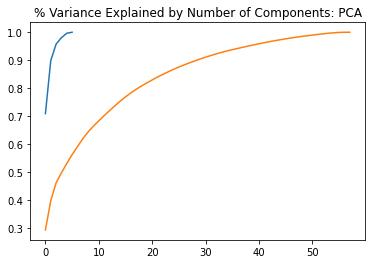

In [5]:
#PCA
# Kickstart
pca_kickstart=PCA().fit(kickstart_train_x_scaled)
plt.plot(pd.DataFrame(pca_kickstart.explained_variance_ratio_).cumsum())
n_to_keep_kickstart=3
pca_kickstart_data_full=pd.DataFrame(PCA().fit_transform(kickstart_train_x_scaled))
pca_kickstart_data=pd.DataFrame(PCA(n_components=n_to_keep_kickstart).fit_transform(kickstart_train_x_scaled))
pca_kickstart_eigen=pd.DataFrame(pca_kickstart.components_)
             
# Spam
pca_spam=PCA().fit(spam_x_scaled)
plt.plot(pd.DataFrame(pca_spam.explained_variance_ratio_).cumsum())
n_to_keep_spam=20
pca_spam_data_full=pd.DataFrame(PCA().fit_transform(spam_x_scaled))
pca_spam_data=pd.DataFrame(PCA(n_components=n_to_keep_spam).fit_transform(spam_x_scaled))
pca_spam_eigen=pd.DataFrame(pca_spam.components_)

plt.title('% Variance Explained by Number of Components: PCA')

In [6]:
sns.heatmap(abs(pca_kickstart_eigen),xticklabels=kickstart_train_x.columns)
plt.title('Eigenvalues of PCA for Kickstart Data')
plt.show()

sns.heatmap(abs(pca_spam_eigen),xticklabels=spam_x.columns)
plt.title('Eigenvalues of PCA for Spam Data')
plt.show()



SyntaxError: unexpected EOF while parsing (<ipython-input-6-a70c9efe6839>, line 10)

In [11]:
# Finish this
# Does PCA give us same clusters when all features are used

# Kmeans
pca_kickstart_kmeans_full=KMeans(n_clusters=k, n_init=20,max_iter=500).fit(pca_kickstart_data_full)
pca_spam_kmeans_full=KMeans(n_clusters=k, n_init=20,max_iter=500).fit(pca_spam_data_full)

# GMM
pca_kickstart_gmm_full=gmm(k,pca_kickstart_data_full)
pca_spam_gmm_full=gmm(k,pca_spam_data_full)

NameError: name 'k' is not defined

In [182]:
# Kmeans Kickstart partial
ks=range(1,max_k)
pca_kickstart_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(pca_kickstart_data) for k in ks]
pca_kickstart_intertia=[kmeans.inertia_ for kmeans in pca_kickstart_kmeans]
pca_kickstart_entropy=[get_entropy(kmeans,pca_kickstart_data,kickstart_train_y) for kmeans in pca_kickstart_kmeans]

kmeans_results_pca_kickstart=pd.DataFrame(data={'k':list(ks),'dataset':['kickstart']*len(ks),'intertia':pca_kickstart_intertia,'entropy':pca_kickstart_entropy})

# Kmeans Spam partial
ks=range(1,max_k)
pca_spam_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(pca_spam_data) for k in ks]
pca_spam_intertia=[kmeans.inertia_ for kmeans in pca_spam_kmeans]
pca_spam_entropy=[get_entropy(kmeans,pca_spam_data,['y' if spam_y.iloc[i][0] else 'n'  for i in range(len(spam_y))]) for kmeans in pca_spam_kmeans]

kmeans_results_pca_spam=pd.DataFrame(data={'k':list(ks),'dataset':['spam']*len(ks),'intertia':pca_spam_intertia,'entropy':pca_spam_entropy})

kmeans_results_pca=pd.concat([kmeans_results_pca_kickstart,kmeans_results_pca_spam])
kmeans_results_pca.to_csv('results/kmeans_pca_data.csv')

In [9]:
# gmm Kickstart partial 
ks=range(1,max_k)
pca_kickstart_em=[gmm(k,pca_kickstart_data) for k in ks]
gmm_results_pca_kickstart=gmm_get_results('kickstart',ks,pca_kickstart_em,pca_kickstart_data,kickstart_train_y)

# gmm Spam partial
ks=range(1,max_k)
pca_spam_em=[gmm(k,pca_spam_data) for k in ks]
gmm_results_pca_spam=gmm_get_results('spam',ks,pca_spam_em,pca_spam_data,spam_y['ham'])

gmm_results_pca_data=pd.concat([gmm_results_pca_kickstart,gmm_results_pca_spam])
gmm_results_pca_data.to_csv('results/gmm_results_pca_data.csv')


Running iteration for k:1
Running iteration for k:2
Running iteration for k:3
Running iteration for k:4
Running iteration for k:5
Running iteration for k:6
Running iteration for k:7
Running iteration for k:8
Running iteration for k:9
Running iteration for k:10
Running iteration for k:11
Running iteration for k:12
Running iteration for k:13
Running iteration for k:14
Running iteration for k:1
Running iteration for k:2
Running iteration for k:3
Running iteration for k:4
Running iteration for k:5
Running iteration for k:6
Running iteration for k:7
Running iteration for k:8
Running iteration for k:9
Running iteration for k:10
Running iteration for k:11
Running iteration for k:12
Running iteration for k:13
Running iteration for k:14


# Randomized Projections as input

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 7).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 8).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 9).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 10).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 11).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 11).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 11).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 11).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 11).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 12).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 13).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 13).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 13).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 14).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 15).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 15).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 15).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 18).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 18).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 18).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 19).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 20).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 21).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 21).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 21).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 21).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 21).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 21).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 22).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 22).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 22).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 22).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 22).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 23).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 23).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 23).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 23).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 24).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 24).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 24).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 24).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 24).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (6 < 24).The dimensionality of the problem will not be reduced.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\random_projection.py:385: DataDimensionalityWarning: The number of components is higher than the number of features: n_features 

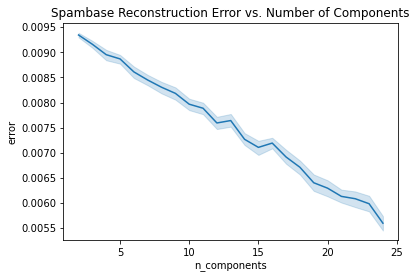

In [35]:
# Lemma led to a larger feature size than original data. Used input size as PCA
def get_reconstruction_error(data,model):
        transformed_data=model.fit_transform(data)
        inverse_data = np.linalg.pinv(model.components_.T)
        reconstructed_data = transformed_data.dot(inverse_data)
        return (np.square(data-reconstructed_data).mean(axis=None))

def run_random_projection(n_components,n_runs,data):
    rca_data=[GaussianRandomProjection(n_components=n_components) for i in range(n_runs)]
    rca_error=[get_reconstruction_error(data,rca) for rca in rca_data]
    return(pd.DataFrame(data={'n_components':[n_components]*n_runs,'error':rca_error}))

random_test_kickstart=pd.concat([run_random_projection(i,50,kickstart_train_x_scaled) for i in range(2,25)])
random_test_spam=pd.concat([run_random_projection(i,50,spam_x_scaled) for i in range(2,25)])

sns.lineplot(data=random_test_kickstart, x="n_components", y="error")
plt.title('Kickstart Reconstruction Error vs. Number of Components')
plt.show()

sns.lineplot(data=random_test_spam, x="n_components", y="error")
plt.title('Spambase Reconstruction Error vs. Number of Components')
plt.show()

rca_kickstart_data=GaussianRandomProjection(n_components=n_to_keep_kickstart).fit_transform(kickstart_train_x_scaled)
rca_spam_data=GaussianRandomProjection(n_components=n_to_keep_spam).fit_transform(spam_x_scaled)


In [36]:
# Kmeans Kickstart partial
ks=range(1,max_k)
rca_kickstart_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(rca_kickstart_data) for k in ks]
rca_kickstart_intertia=[kmeans.inertia_ for kmeans in rca_kickstart_kmeans]
rca_kickstart_entropy=[get_entropy(kmeans,rca_kickstart_data,kickstart_train_y) for kmeans in rca_kickstart_kmeans]

kmeans_results_rca_kickstart=pd.DataFrame(data={'k':list(ks),'dataset':['kickstart']*len(ks),'intertia':rca_kickstart_intertia,'entropy':rca_kickstart_entropy})

# Kmeans Spam partial
ks=range(1,max_k)
rca_spam_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(rca_spam_data) for k in ks]
rca_spam_intertia=[kmeans.inertia_ for kmeans in rca_spam_kmeans]
rca_spam_entropy=[get_entropy(kmeans,rca_spam_data,['y' if spam_y.iloc[i][0] else 'n'  for i in range(len(spam_y))]) for kmeans in rca_spam_kmeans]

kmeans_results_rca_spam=pd.DataFrame(data={'k':list(ks),'dataset':['spam']*len(ks),'intertia':rca_spam_intertia,'entropy':rca_spam_entropy})

kmeans_results_rca=pd.concat([kmeans_results_rca_kickstart,kmeans_results_rca_spam])
kmeans_results_rca.to_csv('results/kmeans_rca_data.csv')


In [ ]:
# gmm Kickstart partial 
ks=range(1,max_k)
rca_kickstart_em=[gmm(k,rca_kickstart_data) for k in ks]
gmm_results_rca_kickstart=gmm_get_results('kickstart',ks,rca_kickstart_em,rca_kickstart_data,kickstart_train_y)

# gmm Spam partial
ks=range(1,max_k)
rca_spam_em=[gmm(k,rca_spam_data) for k in ks]
gmm_results_rca_spam=gmm_get_results('spam',ks,rca_spam_em,rca_spam_data,spam_y['ham'])

gmm_results_rca_data=pd.concat([gmm_results_rca_kickstart,gmm_results_rca_spam])
gmm_results_rca_data.to_csv('results/gmm_results_rca_data.csv')

# ICA as Input

In [ ]:
# should really try different number of components but not enough time. 
# The blind sources do not necessarily need to be the classes. They could be something else.
# For spam it could be topics. For kicktarter it could again be topics, or categories, each having their own rate of success and failure
# One method could be to run ICA for all pairs of blind sources and K and select lowest entropy 

kickstart_ica_test=[pd.DataFrame(FastICA(n_components=i).fit_transform(kickstart_train_x_scaled)) for i in range(2,6)]
spam_ica_test=[pd.DataFrame(FastICA(n_components=i).fit_transform(spam_x_scaled)) for i in range(2,25)]

kurtosis_kickstart=[np.mean(kurtosis(data)) for data in kickstart_ica_test]
kurtosis_spam=[np.mean(kurtosis(data)) for data in spam_ica_test ]


plt.plot(kurtosis_kickstart)
plt.title('Kickstart Kurtosis Error vs. Number of Components')
plt.show()

plt.plot(kurtosis_spam)
plt.title('Spambase Kurtosis Error vs. Number of Components')
plt.show()

ica_kickstart_data=[pd.DataFrame(FastICA(n_components=2).fit_transform(kickstart_train_x_scaled))]
ica_kickstart_data
ica_spam_data=[pd.DataFrame(FastICA(n_components=14).fit_transform(spam_x_scaled))]

In [13]:
# ica=FastICA(n_components=2)
# ica.fit_transform(kickstart_train_x_scaled)
# sns.heatmap(ica.mixing_,yticklabels=kickstart_train_x.columns)
# plt.title("Mixing Matrix for Kickstart Data")
# plt.show()

# ica2=FastICA(n_components=14)
# ica2.fit_transform(spam_x_scaled)
ica_spam=pd.DataFrame(ica2.mixing_)
# ica_spam['column']=spam_x.columns

ica_spam_rel_freq=ica_spam / abs(ica_spam).sum(axis=1)[:,None]
ica_spam_rel_freq['column']=spam_x.columns
ica_spam_rel_freq.iloc[:][[3,'column']].sort_values(3,ascending=False)

NameError: name 'ica2' is not defined

In [15]:
# Kmeans Kickstart partial
ks=range(1,max_k)
ica_kickstart_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(ica_kickstart_data) for k in ks]
ica_kickstart_intertia=[kmeans.inertia_ for kmeans in ica_kickstart_kmeans]
ica_kickstart_entropy=[get_entropy(kmeans,ica_kickstart_data,kickstart_train_y) for kmeans in ica_kickstart_kmeans]

kmeans_results_ica_kickstart=pd.DataFrame(data={'k':list(ks),'dataset':['kickstart']*len(ks),'intertia':ica_kickstart_intertia,'entropy':ica_kickstart_entropy})

# Kmeans Spam partial
ks=range(1,max_k)
ica_spam_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(ica_spam_data) for k in ks]
ica_spam_intertia=[kmeans.inertia_ for kmeans in ica_spam_kmeans]
ica_spam_entropy=[get_entropy(kmeans,ica_spam_data,['y' if spam_y.iloc[i][0] else 'n'  for i in range(len(spam_y))]) for kmeans in ica_spam_kmeans]

kmeans_results_ica_spam=pd.DataFrame(data={'k':list(ks),'dataset':['spam']*len(ks),'intertia':ica_spam_intertia,'entropy':ica_spam_entropy})

kmeans_results_ica=pd.concat([kmeans_results_ica_kickstart,kmeans_results_ica_spam])
kmeans_results_ica.to_csv('results/kmeans_ica_data.csv')


ValueError: cannot copy sequence with size 302928 to array axis with dimension 2

In [16]:
# gmm Kickstart partial 
ks=range(1,max_k)
ica_kickstart_em=[gmm(k,ica_kickstart_data) for k in ks]
gmm_results_ica_kickstart=gmm_get_results('kickstart',ks,ica_kickstart_em,ica_kickstart_data,kickstart_train_y)

# gmm Spam partial
ks=range(1,max_k)
ica_spam_em=[gmm(k,ica_spam_data) for k in ks]
gmm_results_ica_spam=gmm_get_results('spam',ks,ica_spam_em,ica_spam_data,spam_y['ham'])

gmm_results_ica_data=pd.concat([gmm_results_ica_kickstart,gmm_results_ica_spam])
gmm_results_ica_data.to_csv('results/gmm_results_ica_data.csv')

Running iteration for k:1


ValueError: cannot copy sequence with size 302928 to array axis with dimension 2

# Factor Analysis as Input

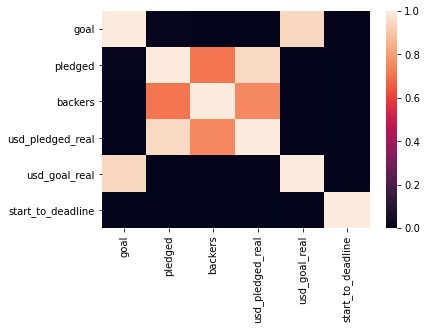

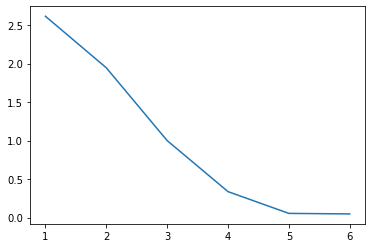

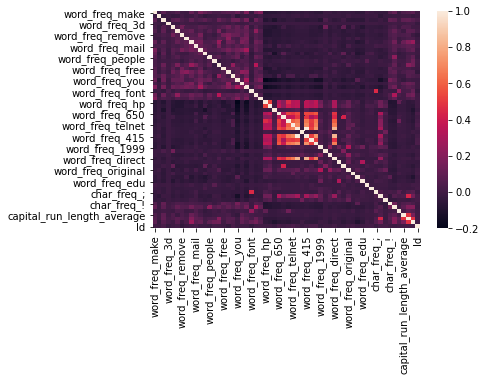

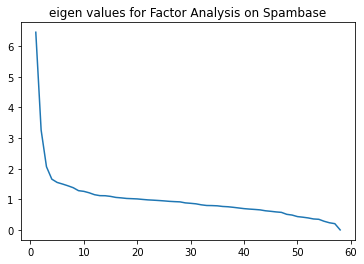

In [20]:
# https://www.datacamp.com/community/tutorials/introduction-factor-analysis

# Kickstart
sns.heatmap(pd.DataFrame(kickstart_train_x).corr())
plt.show()
fa_kickstart = FactorAnalyzer()
fa_kickstart.fit(kickstart_train_x_scaled, 6)
ev, v = fa_kickstart.get_eigenvalues()
ev
plt.plot(range(1,kickstart_train_x_scaled.shape[1]+1),ev)
plt.show()

# Spam
sns.heatmap(pd.DataFrame(spam_x).corr())
plt.show()
fa_spam = FactorAnalyzer()
fa_spam.fit(spam_x_scaled, 20)
ev, v = fa_spam.get_eigenvalues()
ev
plt.plot(range(1,spam_x_scaled.shape[1]+1),ev)
plt.title('eigen values for Factor Analysis on Spambase')
plt.show()




In [21]:
# Spam
fa_spam_final = FactorAnalyzer(8,rotation='varimax')
fa_spam_final.fit(spam_x_scaled)

loadings_spam=pd.DataFrame(fa_spam_final.loadings_)
loadings_spam['column']=spam_x.columns
loadings_spam['factor']=[list(loadings_spam.loc[i][:]).index(max(loadings_spam.loc[i][0:8])) for i in range(len(loadings_spam))]

# Check out factors 
loadings_spam[loadings_spam['factor']==2]['column']

fa_spam_data=pd.DataFrame(fa_spam_final.fit_transform(spam_x_scaled))

In [23]:
# Kickstart
fa_kickstart_final = FactorAnalyzer(2,rotation='varimax')
fa_kickstart_final.fit(kickstart_train_x_scaled)

loadings_kickstart=pd.DataFrame(fa_kickstart_final.loadings_)
loadings_kickstart['column']=kickstart_train_x.columns
loadings_kickstart

fa_kickstart_data=pd.DataFrame(fa_kickstart_final.fit_transform(kickstart_train_x_scaled))

# Spam
fa_spam_final = FactorAnalyzer(8,rotation='varimax')
fa_spam_final.fit(spam_x_scaled)

loadings_spam=pd.DataFrame(fa_spam_final.loadings_)
loadings_spam['column']=spam_x.columns
loadings_spam['factor']=[list(loadings_spam.loc[i][:]).index(max(loadings_spam.loc[i][0:8])) for i in range(len(loadings_spam))]

# Check out factors 
loadings_spam[loadings_spam['factor']==2]['column']

fa_spam_data=pd.DataFrame(fa_spam_final.fit_transform(spam_x_scaled))

In [24]:
# Kmeans Kickstart partial
ks=range(1,max_k)
fa_kickstart_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(fa_kickstart_data) for k in ks]
fa_kickstart_intertia=[kmeans.inertia_ for kmeans in fa_kickstart_kmeans]
fa_kickstart_entropy=[get_entropy(kmeans,fa_kickstart_data,kickstart_train_y) for kmeans in fa_kickstart_kmeans]

kmeans_results_fa_kickstart=pd.DataFrame(data={'k':list(ks),'dataset':['kickstart']*len(ks),'intertia':fa_kickstart_intertia,'entropy':fa_kickstart_entropy})

# Kmeans Spam partial
ks=range(1,max_k)
fa_spam_kmeans=[KMeans(n_clusters=k, n_init=20,max_iter=500).fit(fa_spam_data) for k in ks]
fa_spam_intertia=[kmeans.inertia_ for kmeans in fa_spam_kmeans]
fa_spam_entropy=[get_entropy(kmeans,fa_spam_data,['y' if spam_y.iloc[i][0] else 'n'  for i in range(len(spam_y))]) for kmeans in fa_spam_kmeans]
kmeans_results_fa_spam=pd.DataFrame(data={'k':list(ks),'dataset':['spam']*len(ks),'intertia':fa_spam_intertia,'entropy':fa_spam_entropy})

kmeans_results_fa=pd.concat([kmeans_results_fa_kickstart,kmeans_results_fa_spam])
kmeans_results_fa.to_csv('results/kmeans_fa_data.csv')

In [ ]:
# gmm Kickstart partial 
ks=range(1,max_k)
fa_kickstart_em=[gmm(k,fa_kickstart_data) for k in ks]
gmm_results_fa_kickstart=gmm_get_results('kickstart',ks,fa_kickstart_em,fa_kickstart_data,kickstart_train_y)

# gmm Spam partial
ks=range(1,max_k)
fa_spam_em=[gmm(k,fa_spam_data) for k in ks]
gmm_results_fa_spam=gmm_get_results('spam',ks,fa_spam_em,fa_spam_data,spam_y['ham'])

gmm_results_fa_data=pd.concat([gmm_results_fa_kickstart,gmm_results_fa_spam])
gmm_results_fa_data.to_csv('results/gmm_results_fa_data.csv')

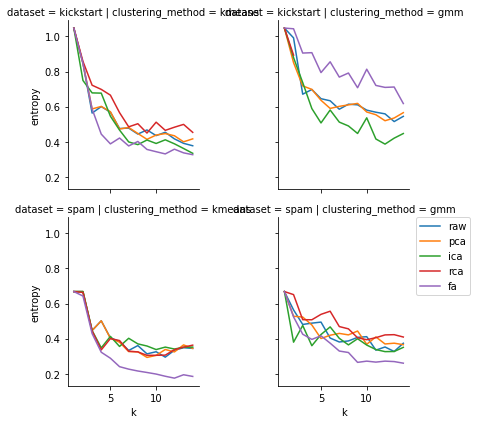

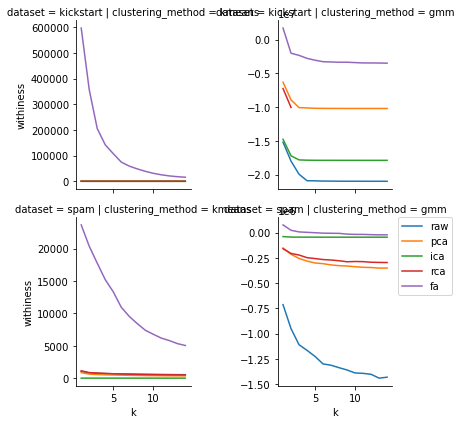

In [25]:
kmeans_raw=pd.read_csv('results/kmeans_raw_data.csv')
kmeans_raw['data']='raw'

kmeans_pca=pd.read_csv('results/kmeans_pca_data.csv')
kmeans_pca['data']='pca'

kmeans_ica=pd.read_csv('results/kmeans_ica_data.csv')
kmeans_ica['data']='ica'

kmeans_rca=pd.read_csv('results/kmeans_rca_data.csv')
kmeans_rca['data']='rca'

kmeans_fa=pd.read_csv('results/kmeans_fa_data.csv')
kmeans_fa['data']='fa'

kmeans_all=pd.concat([kmeans_raw,kmeans_pca,kmeans_ica,kmeans_rca,kmeans_fa])
kmeans_all['clustering_method']='kmeans'
kmeans_all['withiness']=kmeans_all['intertia']

gmm_raw=pd.read_csv('results/gmm_results_raw_data.csv')
gmm_raw['data']='raw'

gmm_pca=pd.read_csv('results/gmm_results_pca_data.csv')
gmm_pca['data']='pca'

gmm_ica=pd.read_csv('results/gmm_results_ica_data.csv')
gmm_ica['data']='ica'

gmm_rca=pd.read_csv('results/gmm_results_rca_data.csv')
gmm_rca['data']='rca'

gmm_fa=pd.read_csv('results/gmm_results_fa_data.csv')
gmm_fa['data']='fa'

gmm_all=pd.concat([gmm_raw,gmm_pca,gmm_ica,gmm_rca,gmm_fa])
gmm_all['clustering_method']='gmm'
gmm_all['withiness']=gmm_all['aic']

all_models=pd.concat([kmeans_all,gmm_all])

g = sns.FacetGrid(data=all_models, col="clustering_method", hue="data",row='dataset')
g.map(sns.lineplot, "k", "entropy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


g2 = sns.FacetGrid(data=all_models, col="clustering_method", hue="data",row='dataset',sharey=False)
g2.map(sns.lineplot, "k", "withiness")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# kickstart_final_ks={'raw':,'pca':,'ica':,'rca':2,'fa':}


In [166]:
def run_clustering(k,method,data):
    if method=='kmeans':
        model=KMeans(n_clusters=k, n_init=20,max_iter=500).fit(data)
    else: 
        model=GaussianMixture(n_components=k, n_init=20,max_iter=500,covariance_type='full').fit(data)
        
    return(model)

def add_clusters(data,model,orig_data):
    orig_data=pd.DataFrame(orig_data)
    orig_data['cluster']=model.predict(data)
    return(orig_data)

kickstart_datasets=[kickstart_train_x_scaled,pca_kickstart_data,ica_kickstart_data[0],rca_kickstart_data,fa_kickstart_data]

kickstart_models=[run_clustering(5,'kmeans',data) for data in kickstart_datasets]
kickstart_clusters=[add_clusters(kickstart_datasets[i],kickstart_models[i],kickstart_train_x) for i in range(len(kickstart_datasets))]

kickstart_models_gmm=[run_clustering(5,'gmm',data) for data in kickstart_datasets]
kickstart_clusters_gmm=[add_clusters(kickstart_datasets[i],kickstart_models_gmm[i],kickstart_train_x) for i in range(len(kickstart_datasets))]

In [235]:
spam_datasets=[spam_x_scaled,pca_spam_data,ica_spam_data[0],rca_spam_data,fa_spam_data]
spam_models=[run_clustering(5,'kmeans',data) for data in spam_datasets]
spam_clusters=[add_clusters(spam_datasets[i],spam_models[i],spam_x_scaled) for i in range(len(spam_datasets))]

spam_models_gmm=[run_clustering(5,'gmm',data) for data in spam_datasets]
spam_clusters_gmm=[add_clusters(spam_datasets[i],spam_models_gmm[i],spam_x) for i in range(len(spam_datasets))]

C:\Users\Rory\anaconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


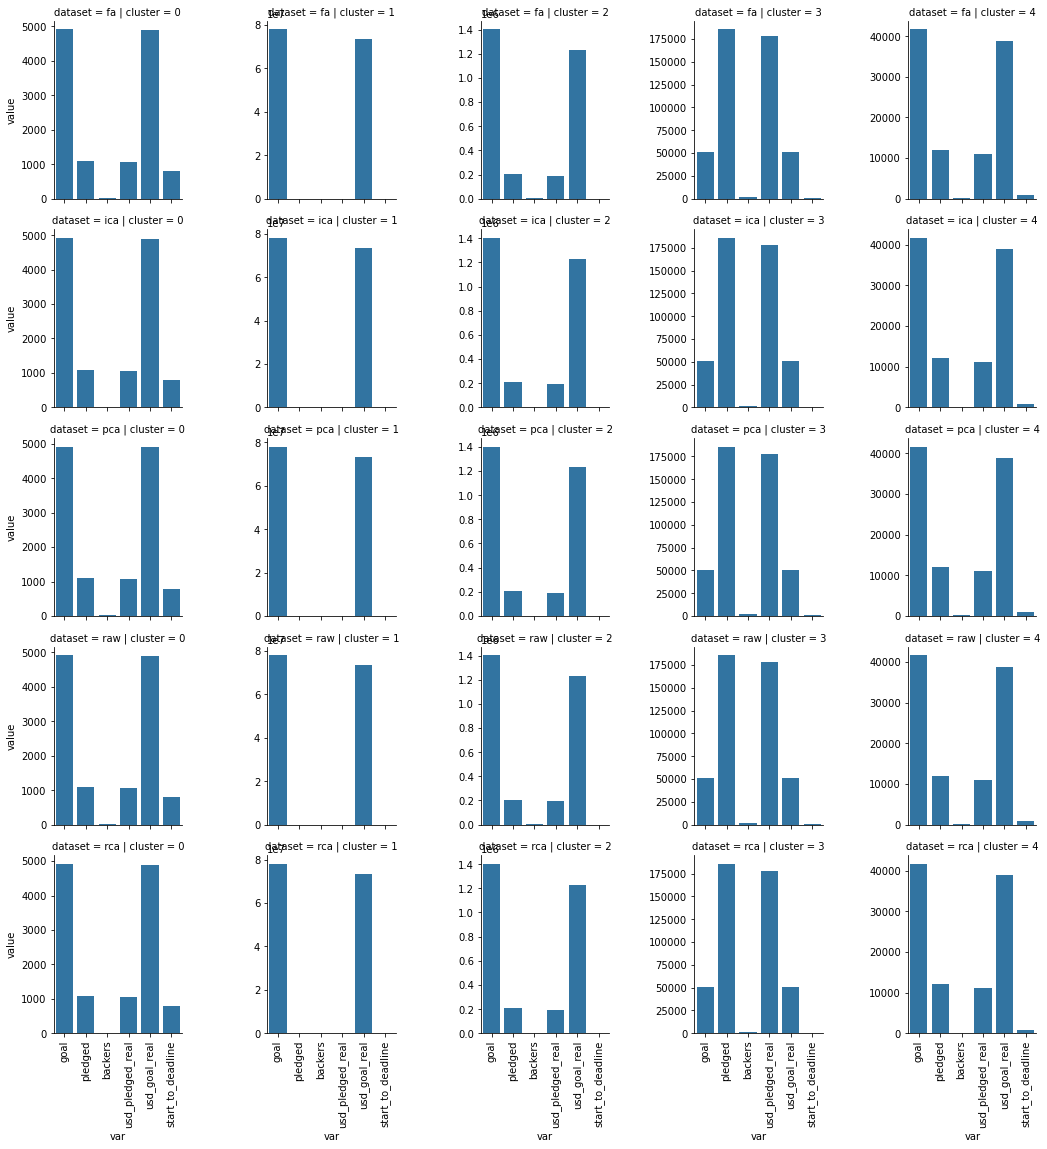

In [234]:
kickstart_clusters_p=pd.concat(kickstart_clusters)
kickstart_clusters_p['dataset']=['raw']*len(kickstart_train_x)+['pca']*len(kickstart_train_x)+['ica']*len(kickstart_train_x)+['rca']*len(kickstart_train_x)+['fa']*len(kickstart_train_x)
avgs=kickstart_clusters_p.groupby(['dataset','cluster']).mean().reset_index()
avgs_long=pd.melt(avgs, id_vars=['dataset', 'cluster'], var_name='var', value_name='value')
g=sns.FacetGrid(data=avgs_long,col='cluster',row='dataset',sharey=False)
g.map(sns.barplot,'var','value')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

C:\Users\Rory\anaconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


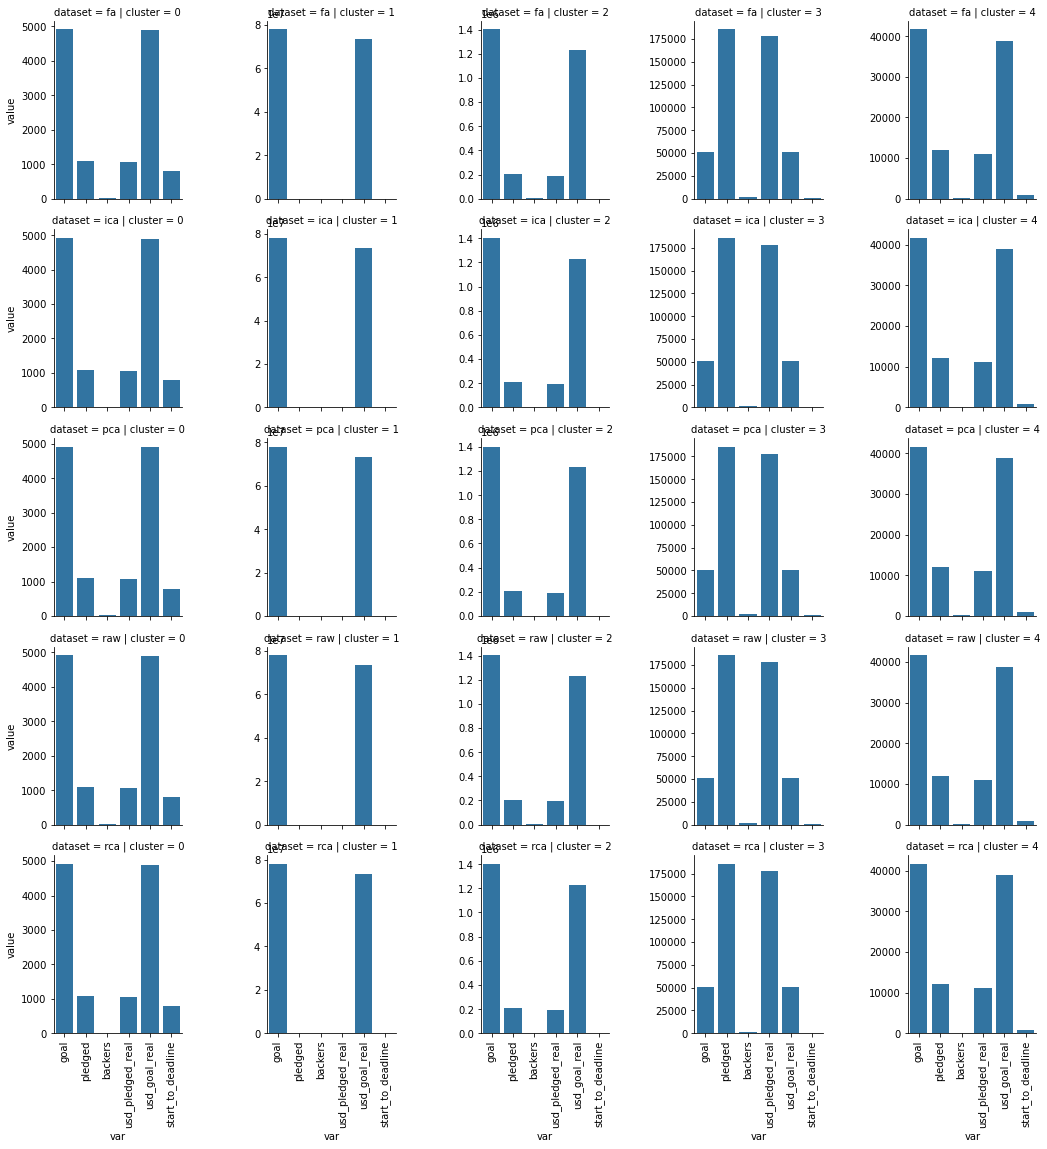

In [167]:
kickstart_clusters_gmm_p=pd.concat(kickstart_clusters_gmm)
kickstart_clusters_gmm_p['dataset']=['raw']*len(kickstart_train_x)+['pca']*len(kickstart_train_x)+['ica']*len(kickstart_train_x)+['rca']*len(kickstart_train_x)+['fa']*len(kickstart_train_x)
avgs=kickstart_clusters_gmm_p.groupby(['dataset','cluster']).mean().reset_index()
avgs_long=pd.melt(avgs, id_vars=['dataset', 'cluster'], var_name='var', value_name='value')
g=sns.FacetGrid(data=avgs_long,col='cluster',row='dataset',sharey=False)
g.map(sns.barplot,'var','value')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()

In [261]:
spam_clusters_p=pd.concat(spam_clusters)
spam_clusters_p['dataset']=['raw']*len(spam_x)+['pca']*len(spam_x)+['ica']*len(spam_x)+['rca']*len(spam_x)+['fa']*len(spam_x)
spam_clusters_p.columns.values[0:58]=spam_x.columns.values[0:58]
avgs=spam_clusters_p.groupby(['dataset','cluster']).mean().reset_index()
avgs_long=pd.melt(avgs, id_vars=['dataset', 'cluster'], var_name='var', value_name='value')

avgs_long_tf=pd.merge(avgs_long,avgs_long.groupby(['dataset','var']).sum().reset_index()[['dataset','var','value']],on=['dataset','var'])
avgs_long_tf['importance']=avgs_long_tf['value_x']/avgs_long_tf['value_y']
avgs_long_tf['importance_rank'] = avgs_long_tf.sort_values(['importance'], ascending=False)\
             .groupby(['cluster','dataset'])\
             .cumcount() + 1
top5=avgs_long_tf[avgs_long_tf['importance_rank']<=5]
g=sns.FacetGrid(data=top5,col='cluster',row='dataset',sharex=False)
g.map(sns.barplot,'var','importance')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]
plt.show()



dataset  cluster             var     value
0         fa        0  word_freq_make  0.022448
1         fa        1  word_freq_make  0.000000
2         fa        2  word_freq_make  0.012756
3         fa        3  word_freq_make  0.000000
4         fa        4  word_freq_make  0.007027
...      ...      ...             ...       ...
1445     rca        0              Id  0.468128
1446     rca        1              Id  0.256871
1447     rca        2              Id  0.732327
1448     rca        3              Id  0.575841
1449     rca        4              Id  0.553199

[1450 rows x 4 columns]

In [232]:
random_index=random.sample(range(0, len(kickstart_train_x_scaled)), 50000)
train_x=pd.DataFrame(kickstart_train_x_scaled).iloc[random_index]
train_y=pd.DataFrame(kickstart_train_y).iloc[random_index]

# create training_sets
raw_train=train_x

# without clusters
pca_model=PCA(n_components=n_to_keep_kickstart).fit(train_x)
pca_train=pca_model.transform(train_x)

ica_model=FastICA(n_components=2).fit(train_x)
ica_train=ica_model.transform(train_x)

rca_model=GaussianRandomProjection(n_components=3).fit(train_x)
rca_train=rca_model.transform(train_x)

fa_model=FactorAnalyzer(2,rotation='varimax').fit(train_x)
fa_train=fa_model.transform(train_x)

# with clusters
raw_km_train,raw_gmm_train=pd.DataFrame(raw_train).copy(),pd.DataFrame(raw_train).copy()
raw_km_model=run_clustering(5,'kmeans',raw_train.copy())
raw_km_train['cluster']=raw_km_model.predict(raw_train)
raw_gmm_model=run_clustering(5,'gmm',raw_train.copy())
raw_gmm_train['cluster']=raw_gmm_model.predict(raw_train)

pca_km_train,pca_gmm_train=pd.DataFrame(pca_train).copy(),pd.DataFrame(pca_train).copy()
pca_km_model=run_clustering(5,'kmeans',pca_train.copy())
pca_km_train['cluster']=pca_km_model.predict(pca_train)
pca_gmm_model=run_clustering(5,'gmm',pca_train.copy())
pca_gmm_train['cluster']=pca_gmm_model.predict(pca_train)

ica_km_train,ica_gmm_train=pd.DataFrame(ica_train).copy(),pd.DataFrame(ica_train).copy()
ica_km_model=run_clustering(5,'kmeans',ica_train.copy())
ica_km_train['cluster']=ica_km_model.predict(ica_train)
ica_gmm_model=run_clustering(5,'gmm',ica_train.copy())
ica_gmm_train['cluster']=ica_gmm_model.predict(ica_train)

rca_km_train,rca_gmm_train=pd.DataFrame(rca_train).copy(),pd.DataFrame(rca_train).copy()
rca_km_model=run_clustering(5,'kmeans',rca_train.copy())
rca_km_train['cluster']=rca_km_model.predict(rca_train)
rca_gmm_model=run_clustering(5,'gmm',rca_train.copy())
rca_gmm_train['cluster']=rca_gmm_model.predict(rca_train)

fa_km_train,fa_gmm_train=pd.DataFrame(fa_train).copy(),pd.DataFrame(fa_train).copy()
fa_km_model=run_clustering(5,'kmeans',fa_train.copy())
fa_km_train['cluster']=fa_km_model.predict(fa_train)
fa_gmm_model=run_clustering(5,'gmm',fa_train.copy())
fa_gmm_train['cluster']=fa_gmm_model.predict(fa_train)

# create test sets
raw_test=pd.DataFrame(kickstart_test_x_scaled)
pca_test=pd.DataFrame(pca_model.transform(kickstart_test_x_scaled))
rca_test=pd.DataFrame(rca_model.transform(kickstart_test_x_scaled))
ica_test=pd.DataFrame(ica_model.transform(kickstart_test_x_scaled))
fa_test=pd.DataFrame(fa_model.transform(kickstart_test_x_scaled)) 

raw_km_test=raw_test.copy()
raw_km_test['cluster']=raw_km_model.predict(raw_test)
pca_km_test=pca_test.copy()
pca_km_test['cluster']=pca_km_model.predict(pca_test)
ica_km_test=ica_test.copy()
ica_km_test['cluster']=ica_km_model.predict(ica_test)
rca_km_test=rca_test.copy()
rca_km_test['cluster']=rca_km_model.predict(rca_test)
fa_km_test=fa_test.copy()
fa_km_test['cluster']=fa_km_model.predict(fa_test)

raw_gmm_test=raw_test.copy()
raw_gmm_test['cluster']=raw_gmm_model.predict(raw_test)
pca_gmm_test=pca_test.copy()
pca_gmm_test['cluster']=pca_gmm_model.predict(pca_test)
ica_gmm_test=ica_test.copy()
ica_gmm_test['cluster']=ica_gmm_model.predict(ica_test)
rca_gmm_test=rca_test.copy()
rca_gmm_test['cluster']=rca_gmm_model.predict(rca_test)
fa_gmm_test=fa_test.copy()
fa_gmm_test['cluster']=fa_gmm_model.predict(fa_test)
                      


In [233]:
def run_model(param_dict):
    clf = MLPClassifier(random_state=1,hidden_layer_sizes=(5,10))
    start=time.time()
    clf.fit(param_dict.get('train_x'),param_dict.get('train_y'))
    end=time.time()
    fit_time=end-start
    training_accuracy=accuracy_score(clf.predict(param_dict.get('train_x')),param_dict.get('train_y'))
    testing_accuracy=accuracy_score(clf.predict(param_dict.get('test_x')),param_dict.get('test_y'))
    return(pd.DataFrame(data={'input_data':[param_dict.get('input')],'training_accuracy':[training_accuracy],'testing_accuracy':[testing_accuracy],'fit_time':[fit_time]}))

raw_dict={'train_x':raw_train,'train_y':train_y,'test_x':raw_test,'test_y':kickstart_test_y,'input':'raw'}
pca_dict={'train_x':pca_train,'train_y':train_y,'test_x':pca_test,'test_y':kickstart_test_y,'input':'pca'}
ica_dict={'train_x':ica_train,'train_y':train_y,'test_x':ica_test,'test_y':kickstart_test_y,'input':'ica'}
rca_dict={'train_x':rca_train,'train_y':train_y,'test_x':rca_test,'test_y':kickstart_test_y,'input':'rca'}
fa_dict={'train_x':fa_train,'train_y':train_y,'test_x':fa_test,'test_y':kickstart_test_y,'input':'fa'}

raw_km_dict={'train_x':raw_km_train,'train_y':train_y,'test_x':raw_km_test,'test_y':kickstart_test_y,'input':'raw_km'}
pca_km_dict={'train_x':pca_km_train,'train_y':train_y,'test_x':pca_km_test,'test_y':kickstart_test_y,'input':'pca_km'}
ica_km_dict={'train_x':ica_km_train,'train_y':train_y,'test_x':ica_km_test,'test_y':kickstart_test_y,'input':'ica_km'}
rca_km_dict={'train_x':rca_km_train,'train_y':train_y,'test_x':rca_km_test,'test_y':kickstart_test_y,'input':'rca_km'}
fa_km_dict={'train_x':fa_km_train,'train_y':train_y,'test_x':fa_km_test,'test_y':kickstart_test_y,'input':'fa_km'}

raw_gmm_dict={'train_x':raw_gmm_train,'train_y':train_y,'test_x':raw_gmm_test,'test_y':kickstart_test_y,'input':'raw_gmm'}
pca_gmm_dict={'train_x':pca_gmm_train,'train_y':train_y,'test_x':pca_gmm_test,'test_y':kickstart_test_y,'input':'pca_gmm'}
ica_gmm_dict={'train_x':ica_gmm_train,'train_y':train_y,'test_x':ica_gmm_test,'test_y':kickstart_test_y,'input':'ica_gmm'}
rca_gmm_dict={'train_x':rca_gmm_train,'train_y':train_y,'test_x':rca_gmm_test,'test_y':kickstart_test_y,'input':'rca_gmm'}
fa_gmm_dict={'train_x':fa_gmm_train,'train_y':train_y,'test_x':fa_gmm_test,'test_y':kickstart_test_y,'input':'fa_gmm'}


all_input_datas=[raw_dict,pca_dict,ica_dict,rca_dict,fa_dict,raw_km_dict,pca_km_dict,ica_km_dict,rca_km_dict,fa_km_dict,raw_gmm_dict,pca_gmm_dict,ica_gmm_dict,rca_gmm_dict,fa_gmm_dict]
output=[run_model(a_dict) for a_dict in all_input_datas]
pd.concat(output).to_csv('results/nn_train.csv')

C:\Users\Rory\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Rory\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Rory\anaconda3\lib\site-pac

[[None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]]

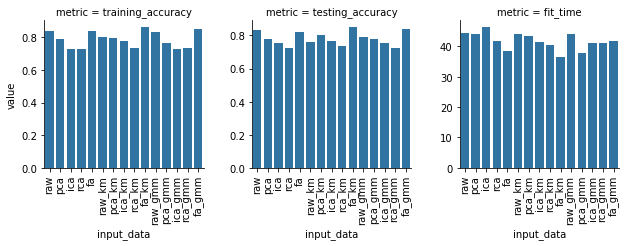

In [293]:
nn_output=pd.read_csv('results/nn_train.csv')
nn_long=pd.melt(nn_output[['input_data','training_accuracy','testing_accuracy','fit_time']], id_vars=['input_data'], var_name='metric', value_name='value')
g=sns.FacetGrid(data=nn_long,col='metric',sharey=False)
g.map(sns.barplot,'input_data','value')
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]